## LSTM

### Long Term Dependency

RNN의 장점 중 하나는 이전 정보를 현재 작업으로 연결할 수 있다는 점 이다.(Memory 사용)  
하지만 이러한 장점으로 인한 단점이 생기게 되는 것이 **Long Term Dependency**이다.  
첫번째의 예를 생각해보자.  
우리가 현재 시점의 뭔가를 얻기 위해서 멀지 않은 최근의 정보만 필요로 할 때도 있다. 예를 들어 이전 단어들을 토대로 다음에 올 단어를 예측하는 언어 모델을 생각해 보자. 만약 우리가 "the clouds are in the sky"에서의 마지막 단어를 맞추고 싶다면, 저 문장 말고는 더 볼 필요도 없다. 마지막 단어는 sky일 것이 분명하다. 이 경우처럼 필요한 정보를 얻기 위한 시간 격차가 크지 않다면, RNN도 지난 정보를 바탕으로 학습할 수 있다.  

<div><img src="https://raw.githubusercontent.com/wjddyd66/wjddyd66.github.io/master/static/img/AI/79.PNG" height="250" width="600" /></div>
<br>
두번째의 예를 생각해보자.  
하지만 반대로 더 많은 문맥을 필요로 하는 경우도 있다. "I grew up in France... I speak fluent French"라는 문단의 마지막 단어를 맞추고 싶다고 생각해보자. 최근 몇몇 단어를 봤을 때 아마도 언어에 대한 단어가 와야 될 것이라 생각할 수는 있지만, 어떤 나라 언어인지 알기 위해서는 프랑스에 대한 문맥을 훨씬 뒤에서 찾아봐야 한다. 이렇게 되면 필요한 정보를 얻기 위한 시간 격차는 굉장히 커지게 된다.  

<div><img src="https://raw.githubusercontent.com/wjddyd66/wjddyd66.github.io/master/static/img/AI/80.PNG" height="250" width="600" /></div>
<br>

위와같은 **Long Term Dependency**가 일어나는 이유를 아래 수식으로 살펴보자.  
**Long Term Dependency**의 이유 2가지는 **vanishing 과 exploding gradients**이다.  


위와 같은 이유는 **Activation Function을 tanh 함수를 사용한 것과 RNN의 특성상 모든 Hidden Layer가 같은 Weight를 공유하기 때문이다.**  

**첫째, tanh**부터 살펴보게 되면 아래 식과 같이 나타낼 수 있다.  
식: <span> $\tanh(x) = {e^{x} - e^{-x} \over e^{x} + e^{-x} } \text{범위:[0,1]}$ </span><br>
미분식: <span> $\tanh\prime(x) = 1-\tanh^2(x) \text{범위:[-1,1]}$ </span>
<br>
위와 같이 tanh 미분식이 -1 ~ 1의 범위를 가지므로 **Backpropagation에서 계속해서 값이 작아지는 vainshing문제가 발생하게 된다.**  

**둘째, Hidden Layer가 같은 Weight를 공유**를 살펴보기 위하여 아래와 같은 코드 실행후 확인하였다.  

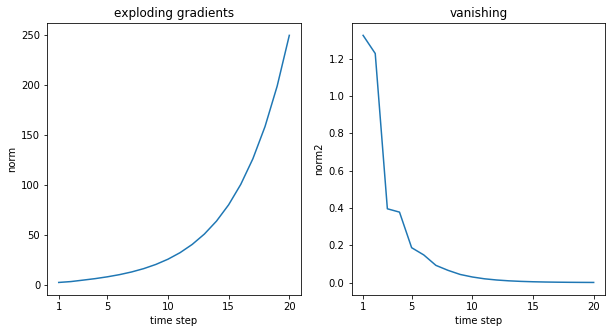

In [1]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


N = 2   # 미니배치 크기
H = 3   # 은닉 상태 벡터의 차원 수
T = 20  # 시계열 데이터의 길이

dh = np.ones((N, H))
dh2 = np.ones((N, H))

np.random.seed(3) # 재현할 수 있도록 난수의 시드 고정

Wh = np.random.randn(H, H)
Wh2 = np.random.randn(H, H) * 0.5

norm_list = []
norm_list2 = []
for t in range(T):
    dh = np.dot(dh, Wh.T)
    dh2 = np.dot(dh2, Wh2.T)
    
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)
    
    norm2 = np.sqrt(np.sum(dh2**2)) / N
    norm_list2.append(norm2)


#print(norm_list)

# 그래프 그리기
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('exploding gradients')
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')

plt.subplot(1,2,2)
plt.title('vanishing')
plt.plot(np.arange(len(norm_list2)), norm_list2)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm2')

plt.show()

Weight 인 Wh가 행렬이므로 행렬의 **'특이값'이 1이상일 경우 Exploding Gradients가 발생하고 '특이값'이 1이하인 경우 vanishing 문제가 발생하게 된다.**

### Exploding Gradients
Exploding Gradients의 해결방법으로 **Gradients Clipping**이 존재한다.  
Gradients Clipping에대한 식은 아래와 같다.  
<p>$if ||\hat{g}|| \ge threshold$</p>
<p>$\hat{g} =  \frac{threshold}{||\hat{g}||}\hat{g}$</p>

**Parameter 설명**  
- <span>$\hat{g}$ </span>: 사용하는 모든 매개변수의 기울기를 하나로 모은 것
- <span>$||\hat{g}||$ </span>: <span>$\hat{g}$ </span>에 L2 norm 적용
- <span>$threshold$ </span>: 문턱값

위와같이 문턱값을 초과하면 문턱값으로 값을 대입하는 것으로 **Exploding Gradients**를 해결할 수 있는 것을 알 수 있다.  

In [1]:
import numpy as np


dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0


def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate


print('before:', dW1.flatten())
clip_grads(grads, max_norm)
print('after:', dW1.flatten())

before: [5.44799518 3.47358019 5.65014947 5.43636298 3.88975196 9.74236234
 2.28613427 5.28779157 4.54053003]
after: [1.02768352 0.6552394  1.06581693 1.02548928 0.73374404 1.83775222
 0.43124534 0.99746349 0.85650367]


### LSTM
**Exploding Gradients은 Exploding Clipping로서 해결하여 vanishing 문제만 해결하면 된다.**  
**vanishing 문제는 RNN에서 Gate를 추가한 LSTM의 형태로서 해결한다.**  

RNN이 많이 사용되는 자연어 처리에서의 예를 들어보자.  
먼저 텍스트 데이터는 이미지와는 다르게 서로 인접한 단어와 Discrete 하다는 특성을 갖는다. 이는 특정단어또는 문장이 주변부 단어 또는 문장과 연관성이 높을 수도 있고 낮을 수도 있음을 의미하며 생성형 요약을 구현하기 위해서는 문장의 길이가 길어져도 각각의 정보를 오래 기억할 수 있어야한다.  
예를 들어“나는 학교에서 밥을 영희와 먹었다.”라는 문장에서 주어인 ‘나’와 ‘영희’는 위치적으로서로가장 떨어져 먼 거리에 위치해있다.  
그런데 주어인 나와 영희의 관계가 가족이라면 나머지 단어들 ‘학교’, ‘밥’ 등 보다 ‘나’는 ‘영희’와 연관성이 더 높다.  
신경망은 이 문장을 받아들일때 ‘나’ 라는 정보를 멀리 떨어진 ‘영희’ 라는 정보와 연관 지을 수있어야한다.  
이러한 텍스트가 갖는 특징에대한 방안으로 Hidden Layer에 LSTM 을 사용하게 된다.  
이러한 LSTM은 아래와 같은 그림으로서 표현할 수 있다.  

<div><img src="http://i.imgur.com/jKodJ1u.png" height="100%" width="100%" /></div>

**LSTM 은 장기 의존성을 해결하기 위한 방안이다. LSTM 은 Forget gate와 Input gate가 특징으로 Forget gate는 과거 정보를 잊기 위한 게이트이다. Input gate 는 현재 정보를 기억하기 위한 게이트이다.**  
두 게이트 모두 앞에 σ(시그모이드)를곱하여 0~1사이에값을 가지게 된다.  
σ(시그모이드)를 곱한 Forget gate 와Input gate를 통해 과거의 정보와 현재의 정보를 얼마나 기억할 것인가를 정하여 장기 의존성의 문제를 해결한다.  
이러한 Forget gate와 Input gate는 아래와 같은 그림으로서 나타낼 수 있다.  

<div><img src="http://i.imgur.com/MPb3OvZ.png" height="100%" width="100%" /></div>
위의 Gate의 설명에서 비선형 효과를 주기 위하여 Activation Function의 종류를 2개 사용하였다.  
각각의 Activation Function과 Parameter에 대해서 알아보자.  

- σ(시그모이드): 0 ~ 1의 범위를 가지게 출력형태를 바꿔주며 데이터를 얼마만큼 통과시킬지를 정하는 비율
- tanh(하이퍼 볼릭 탄젠트): -1 ~ 1의 범위를 가지게 출력형태를 바꿔주며 실질적인 정보의 비율
- Output gate: <span>$o = \sigma (W_{xh_o}x_t +W_{hh_o}h_{t-1} + b_{h_o})$</span>: 다음 시간의 Hidden Layer에서 얼만큼 중요한가를 나타내는 상수
- Forget gate: <span>$f_t = \sigma (W_{xh_f}x_t +W_{hh_f}h_{t-1} + b_{h_f})$</span>: 과거 정보를 잊기 위한 게이트(0 ~ 1사이의 값을 가지는 Scalar로서 얼만큼 잊을지 비율로서 표현)
-  <span>$g$</span>: <span>$tanh(W_{xh_g}x_t +W_{hh_g}h_{t-1} + b_{h_g})$</span>: tanh를 사용하여 현재 LSTM Layer에서의 실질적인 정보의 비율
- Input gate: <span>$i_t = \sigma (W_{xh_i}x_t +W_{hh_i}h_{t-1} + b_{h_i})$</span>: 현재 정보를 기억하기 위한 게이트(0 ~ 1사이의 값을 가지는 Scalar로서 얼만큼 기억할 비율로서 표현)
- <span>$c_t$</span>: 기억 셀로서 과거로부터 시각 t까지에 필요한 모든 정보가 저장된 Cell, <span>$c_t = f \odot c_{t-1} + g \odot i $</span>
- <span>$h_t$</span>: <span>$o \odot tanh(c_t)$</span>: Hidden Layer의 출력 o가 Sigmoid의 Output으로서 상수이므로 <span>$\odot$ </span>사용

위와 같은 LSTM의 망을 **Affine 변환**을 통해 빠르게 계산수행을 위해 아래와 같이 망을 최종적으로 구성한다.  
<div><img src="http://i.imgur.com/73zzDsC.png" height="100%" width="100%" /></div>

In [2]:
class LSTM:
    def __init__(self, Wx, Wh, b):
        '''

        Parameters
        ----------
        Wx: 입력 x에 대한 가중치 매개변수(4개분의 가중치가 담겨 있음)
        Wh: 은닉 상태 h에 대한 가장추 매개변수(4개분의 가중치가 담겨 있음)
        b: 편향（4개분의 편향이 담겨 있음）
        '''
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape

        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b

        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]

        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)

        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)

        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        tanh_c_next = np.tanh(c_next)

        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

        dc_prev = ds * f

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)

        dA = np.hstack((df, dg, di, do))

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev

**위의 결과로부터 BackPropagation 때 Vanishing 문제가 해결되는지 알아보자**  
위의 식에서 <span>$c_t$</span>의 식을 Chain Rule을 사용하여 보자.  
<p>$c_t = f_t \odot c_{t-1} + g \odot i$</p>
<p>$\frac{\partial c_T}{\partial c_t} = \frac{\partial c_T}{\partial c_{T-1}} \frac{\partial c_{T-1}}{\partial c_{T-2}} ... \frac{\partial c_{t+1}}{\partial c_t}$</p>
<p>$\frac{\partial c_T}{\partial c_{T-1}} = f_T, \frac{\partial c_{T-1}}{\partial c_{T-2}} = f_{T-1}, ...,  \frac{\partial c_{t+1}}{\partial c_t} = f_{t+1}$</p>
<p>$\frac{\partial c_T}{\partial c_t} = \prod_{i=t+1}^T f_i$</p>
위의 식에서 f는 sigmoid의 output의 값으로서 1에 가까울수록 과거의 정보를 많이 기억한다는 것이고 Backpropagation에서 Loss의 값은 0 에 가깝게 될 것이고 Optimizer로서 SGD사용시 조금 변화하는 것을 알 수 있다.  

각각의 Gate에 대하여 Backpropagation의 결과는 아래와 같다.  
<div><img src="https://drive.google.com/uc?id=13jvu-aT2SgiRsVHhLHVU9jXloiLHQgt1" height="100%" width="100%" /></div>
위와 같은 그림에서 중요한 점은 <span>$H_T$</span>는 Affine 변환을 통하여 한번에 더해주는 과정을 거쳤으므로 Backpropagation에서도 기울기를 합쳐서 보내는 과정을 거쳐야 된다는 것 이다. 

### Time LSTM
Time LSTM이란 T개분의 시계열 데이터를 한꺼번에 처리하는 계층이다.  
앞선 POST에서의 Time RNN과 다른것은 하나의 Layer를 RNN대시 LSTM으로 하였고 은닉상태와 기억 셀 2개의 값을 인스턴스 변수로 유지한다는 것 이다.  

In [3]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None

위에서 정의한 **Time LSTM**을 활용하여 Softmax직전까지의 Rnnlm을 구성하는 코드이다.  
즉, Embedding -> Time LSTM -> Time Affine까지의 계층 구현이다.  

In [4]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.base_model import BaseModel


class Rnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()

이제 구현한 Rnnlm을 Train하는 Code이다.  
이전 Post에서의 Simple Rnnlm과 다른점은 **Exploding Gradients을 해결하기 위하여 Exploding Clipping을 사용한 것 이다.**  


| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 10002.11
| 에폭 1 |  반복 21 / 1327 | 시간 3[s] | 퍼플렉서티 2612.64
| 에폭 1 |  반복 41 / 1327 | 시간 7[s] | 퍼플렉서티 1253.93
| 에폭 1 |  반복 61 / 1327 | 시간 11[s] | 퍼플렉서티 977.90
| 에폭 1 |  반복 81 / 1327 | 시간 15[s] | 퍼플렉서티 782.97
| 에폭 1 |  반복 101 / 1327 | 시간 19[s] | 퍼플렉서티 640.05
| 에폭 1 |  반복 121 / 1327 | 시간 23[s] | 퍼플렉서티 657.03
| 에폭 1 |  반복 141 / 1327 | 시간 27[s] | 퍼플렉서티 595.01
| 에폭 1 |  반복 161 / 1327 | 시간 31[s] | 퍼플렉서티 587.60
| 에폭 1 |  반복 181 / 1327 | 시간 35[s] | 퍼플렉서티 589.98
| 에폭 1 |  반복 201 / 1327 | 시간 39[s] | 퍼플렉서티 504.04
| 에폭 1 |  반복 221 / 1327 | 시간 43[s] | 퍼플렉서티 487.82
| 에폭 1 |  반복 241 / 1327 | 시간 47[s] | 퍼플렉서티 441.64
| 에폭 1 |  반복 261 / 1327 | 시간 51[s] | 퍼플렉서티 453.01
| 에폭 1 |  반복 281 / 1327 | 시간 55[s] | 퍼플렉서티 448.88
| 에폭 1 |  반복 301 / 1327 | 시간 59[s] | 퍼플렉서티 385.96
| 에폭 1 |  반복 321 / 1327 | 시간 62[s] | 퍼플렉서티 341.99
| 에폭 1 |  반복 341 / 1327 | 시간 66[s] | 퍼플렉서티 401.90
| 에폭 1 |  반복 361 / 1327 | 시간 70[s] | 퍼플렉서티 400.60
| 에폭 1 |  반복 381 / 1327 | 시간 74[s] | 퍼플렉서티 337.25
| 에폭 

| 에폭 3 |  반복 541 / 1327 | 시간 618[s] | 퍼플렉서티 135.76
| 에폭 3 |  반복 561 / 1327 | 시간 622[s] | 퍼플렉서티 117.65
| 에폭 3 |  반복 581 / 1327 | 시간 626[s] | 퍼플렉서티 105.81
| 에폭 3 |  반복 601 / 1327 | 시간 629[s] | 퍼플렉서티 149.75
| 에폭 3 |  반복 621 / 1327 | 시간 633[s] | 퍼플렉서티 142.67
| 에폭 3 |  반복 641 / 1327 | 시간 637[s] | 퍼플렉서티 129.89
| 에폭 3 |  반복 661 / 1327 | 시간 641[s] | 퍼플렉서티 118.54
| 에폭 3 |  반복 681 / 1327 | 시간 645[s] | 퍼플렉서티 98.89
| 에폭 3 |  반복 701 / 1327 | 시간 648[s] | 퍼플렉서티 117.98
| 에폭 3 |  반복 721 / 1327 | 시간 652[s] | 퍼플렉서티 125.60
| 에폭 3 |  반복 741 / 1327 | 시간 656[s] | 퍼플렉서티 106.45
| 에폭 3 |  반복 761 / 1327 | 시간 660[s] | 퍼플렉서티 101.67
| 에폭 3 |  반복 781 / 1327 | 시간 664[s] | 퍼플렉서티 103.33
| 에폭 3 |  반복 801 / 1327 | 시간 667[s] | 퍼플렉서티 116.13
| 에폭 3 |  반복 821 / 1327 | 시간 671[s] | 퍼플렉서티 116.93
| 에폭 3 |  반복 841 / 1327 | 시간 675[s] | 퍼플렉서티 114.14
| 에폭 3 |  반복 861 / 1327 | 시간 679[s] | 퍼플렉서티 120.66
| 에폭 3 |  반복 881 / 1327 | 시간 683[s] | 퍼플렉서티 106.21
| 에폭 3 |  반복 901 / 1327 | 시간 686[s] | 퍼플렉서티 132.95
| 에폭 3 |  반복 921 / 1327 | 시간 690

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 54140 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 54540 missing from current font.
  font.set_text

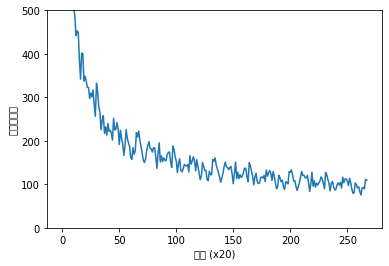

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉서티:  134.85544110439733


In [5]:
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb


# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 35     # RNN을 펼치는 크기
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 기울기 클리핑을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=20)
trainer.plot(ylim=(0, 500))

# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

# 매개변수 저장
model.save_params()

현재 Time LSTM에서 여러가지 기법을 사용하여 좀 더 Model의 퍼블렉서티의 값이 낮아지게 하는 것을 목표로 한다.  

**1. Layer Depth 증가**  
Layer Depth가 증가하게 되면 비선형성이 더욱 증가되어 Data를 예측하는 성능이 높아지게 된다.  
하지만 이러한 Layer Depth를 증가시키면 크게 2가지의 문제가 발생하게 된다.  
1. Layer Depth가 깊어질수록 Hyper Parameter의 수가 증가하게 되며, 학습에 사용할 데이터 양이 제한적일 경우 Overfitting에 빠질 위험이 있다.
2. Layer Depth가 증가하게 되면 연산량이 늘어나게 된다.

현재 사용하는 PTB데이터셋의 언어 모델에서는 LSTM의 층 수는 2~4정도일때 좋은 결과를 만든다고 하여 2층으로 선정하였다.  

**2. Dropout**  
DropOut Dropout은 Overfitting을 막기위한 방법으로 뉴럴 네트워크가 학습중일때, 랜덤하게 뉴런을 꺼서 학습함으로써, 학습이 학습용 데이터로 치우치는 현상을 막아준다.  
<a href="https://wjddyd66.github.io/dl/2019/08/31/NeuralNetwork-(5)-Others.html">Dropout의 자세한 내용</a><br>

**LSTM 의 경우 Dropout의 위치가 중요하게 된다. Dropout의 위치에 따라서 timestep의 정보가 지워져서 시계열 데이터를 사용하는데 어려움을 겪을 수 있기 때문이다.**  

따라서 LSTM에서 권장하는 Dropout의 위치는 다음과 같다.  
<div><img src="https://nmhkahn.github.io/assets/RNN-Reg/p1-dropout.png" height="250" width="600" /></div>

위 그림에서 점선은 dropout이 적용된 연결이고 실선은 dropout이 적용이 되지 않은 것이다. 제시한 방법을 곱씹어보면 이전 timestep에서 온 정보는 dropout 하지 말고, **현재 timestep에서 들어온 입력값 혹은 이전 레이어의 값만 dropout** 하는 의미이다.  
현재 timestep에서 이전 레이어인 <span>$$h_t^{l-1}$$</span>에 dropout을 적용했는데 과거 timestep의 정보를 지우지 않게 하기 위해 recurrent한 연결 (과거 timestep)에 dropout을 적용하지 않은 것으로 보인다. 다시 정리하면, 일반적인 dropout을 적용한다면 먼 과거의 정보를 잃어버려 학습하는데 어려움을 갖지만, **non-recurrent한 연결만 dropout을 적용하면 과거 중요 정보를 희생하지 않아도 regularization을 사용**할 수 있다.

위의 내용을 정리하면 즉, LSTM의 결과 <span>$$c_t^{l}, h_t^{l}$$</span>에서 이전 timestep의 내용을 가지고 있는 <span>$$c_t^{l}$$</span>에 dropout을 적용하게 되면 timestep의 정보가 지워질 수 있다는 것 이다.  

**3. 가중치 공유(Weight Tying)**  
**Weight Tying** 란 입력-임베딩 레이어와 출력 과 softmax 레이어 사이의 가중치 매트릭스 공유 즉, 두 개의 가중치 행렬을 사용하는 대신 하나의 가중치 행렬 만 사용하는 방법이다.  
즉 Embedding을 Encoding이라고 생각하게 되면, Encoding과 Decoding의 방식을 같게한다고 생각할 수 있다.  
실제로 가중치 공유를 하게되면 다음과 같은 2가지 장점을 생각할 수 있다.
1. Hyper Parameter의 수가 감소하게 되여 Overfitting에 빠질 위험 감소
2. Update해야할 Weight감소로 인하여 학습 속도 개선



**실제 구현**  
- LSTM 계층의 다층화(2층)
- Dropout 사용
- 가중치 공유

In [6]:
from common.time_layers import *
from common.np import *  # import numpy as np
from common.base_model import BaseModel


class BetterRnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=650,
                 hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b)  # weight tying!!
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg

        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()

**결과 확인**  
이전 Train과 달리 검증 데이터로 퍼플렉서티를 평가하고, 그 값이 나빠졌을 경우에만 학습률을 낮추는 방법으로 Train을 하였다.  

In [10]:
from common import config
# GPU에서 실행하려면 아래 주석을 해제하세요(CuPy 필요).
# ==============================================
config.GPU = False
# ==============================================
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity, to_gpu
from dataset import ptb


# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 4
max_grad = 0.25
dropout = 0.5

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

if config.GPU:
    corpus = to_gpu(corpus)
    corpus_val = to_gpu(corpus_val)
    corpus_test = to_gpu(corpus_test)

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
                time_size=time_size, max_grad=max_grad)

    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('검증 퍼플렉서티: ', ppl)

    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr

    model.reset_state()
    print('-' * 50)


# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

| 에폭 1 |  반복 1 / 1327 | 시간 1[s] | 퍼플렉서티 10000.24
| 에폭 1 |  반복 21 / 1327 | 시간 25[s] | 퍼플렉서티 3268.14
| 에폭 1 |  반복 41 / 1327 | 시간 50[s] | 퍼플렉서티 1861.89
| 에폭 1 |  반복 61 / 1327 | 시간 75[s] | 퍼플렉서티 1299.86
| 에폭 1 |  반복 81 / 1327 | 시간 100[s] | 퍼플렉서티 1099.30
| 에폭 1 |  반복 101 / 1327 | 시간 125[s] | 퍼플렉서티 833.11
| 에폭 1 |  반복 121 / 1327 | 시간 149[s] | 퍼플렉서티 789.12
| 에폭 1 |  반복 141 / 1327 | 시간 174[s] | 퍼플렉서티 695.42
| 에폭 1 |  반복 161 / 1327 | 시간 202[s] | 퍼플렉서티 683.55
| 에폭 1 |  반복 181 / 1327 | 시간 228[s] | 퍼플렉서티 673.48
| 에폭 1 |  반복 201 / 1327 | 시간 253[s] | 퍼플렉서티 586.21
| 에폭 1 |  반복 221 / 1327 | 시간 279[s] | 퍼플렉서티 577.16
| 에폭 1 |  반복 241 / 1327 | 시간 304[s] | 퍼플렉서티 511.99
| 에폭 1 |  반복 261 / 1327 | 시간 329[s] | 퍼플렉서티 536.13
| 에폭 1 |  반복 281 / 1327 | 시간 354[s] | 퍼플렉서티 523.40
| 에폭 1 |  반복 301 / 1327 | 시간 379[s] | 퍼플렉서티 452.04
| 에폭 1 |  반복 321 / 1327 | 시간 404[s] | 퍼플렉서티 389.26
| 에폭 1 |  반복 341 / 1327 | 시간 430[s] | 퍼플렉서티 443.76
| 에폭 1 |  반복 361 / 1327 | 시간 454[s] | 퍼플렉서티 467.76
| 에폭 1 |  반복 381 / 1327 | 시간 479[s] 

| 에폭 3 |  반복 441 / 1327 | 시간 485[s] | 퍼플렉서티 139.50
| 에폭 3 |  반복 461 / 1327 | 시간 507[s] | 퍼플렉서티 138.08
| 에폭 3 |  반복 481 / 1327 | 시간 529[s] | 퍼플렉서티 135.04
| 에폭 3 |  반복 501 / 1327 | 시간 551[s] | 퍼플렉서티 149.60
| 에폭 3 |  반복 521 / 1327 | 시간 573[s] | 퍼플렉서티 153.00
| 에폭 3 |  반복 541 / 1327 | 시간 595[s] | 퍼플렉서티 158.19
| 에폭 3 |  반복 561 / 1327 | 시간 617[s] | 퍼플렉서티 133.15
| 에폭 3 |  반복 581 / 1327 | 시간 639[s] | 퍼플렉서티 121.91
| 에폭 3 |  반복 601 / 1327 | 시간 661[s] | 퍼플렉서티 170.14
| 에폭 3 |  반복 621 / 1327 | 시간 683[s] | 퍼플렉서티 159.96
| 에폭 3 |  반복 641 / 1327 | 시간 705[s] | 퍼플렉서티 145.27
| 에폭 3 |  반복 661 / 1327 | 시간 727[s] | 퍼플렉서티 136.45
| 에폭 3 |  반복 681 / 1327 | 시간 749[s] | 퍼플렉서티 116.32
| 에폭 3 |  반복 701 / 1327 | 시간 771[s] | 퍼플렉서티 137.36
| 에폭 3 |  반복 721 / 1327 | 시간 793[s] | 퍼플렉서티 140.68
| 에폭 3 |  반복 741 / 1327 | 시간 815[s] | 퍼플렉서티 119.37
| 에폭 3 |  반복 761 / 1327 | 시간 837[s] | 퍼플렉서티 115.40
| 에폭 3 |  반복 781 / 1327 | 시간 859[s] | 퍼플렉서티 119.24
| 에폭 3 |  반복 801 / 1327 | 시간 881[s] | 퍼플렉서티 139.16
| 에폭 3 |  반복 821 / 1327 | 시간 90

현재 그냥 LSTM과 개선된 LSTM을 비교하기 위하여 Epoch를 4로 설정하고 Train하는 중 이다.  
실제 Epoch를 40으로하여 Trainning된 Model은 아래 링크에서 제공되고 있다.

<a href="http://www.oreilly.co.jp/pub/9784873118369/BetterRnnlm.pkl">BetterRnnlm.pkl 다운로드</a><br>